## 1. Load Dataset

### Note: Because of the size limit of github repo, we only upload Round_0/dorothea.zip. Please download other datasets from AutoML challenge website (https://competitions.codalab.org/competitions/2321#participate) and put them to os.path.join(source_dir, 'entire_data/Round_?/dataset_name'), so the following code can be run.                 

### For example, for the dataset 'Round_0/digits' we show below, you need to download it and put it to os.path.join(source_dir, 'entire_data/Round_0/digits').




In [8]:
import sys, os
source_dir = '/Users/lishengsun/Dropbox/Meta-RL/BiDir_SubMatrix/AutoML1_data/'
sys.path.insert(0, source_dir)
data_root_dir = os.path.join(source_dir, 'entire_data')
from lib3.data_manager import DataManager #lib3 for python3
from lib3 import data_io

In [31]:
# load 'digits' from Round_0
data = DataManager(input_dir=os.path.join(data_root_dir, 'Round_0'), basename='digits')
X, y = data.data['X_train'], data.data['Y_train']

Info file found : /Users/lishengsun/Dropbox/Meta-RL/BiDir_SubMatrix/AutoML1_data/entire_data/Round_0/digits/digits_public.info
	Converting to numeric vector
[8. 5. 9. ... 7. 2. 5.]


In [32]:
# original task and the first 5 examples of y in original format
print (data.info['task'])
print (y[:5])

multiclass.classification
[8. 5. 9. 2. 4.]


## 2. Transform classification task to regression task

In [33]:
from bidir_submatrix import helpers
if data.info['task'] != 'regression':
    if data.info['task'] == 'binary.classification':
        X, y = helpers.binary_to_regression(X, y)
    elif data.info['task'] == 'multiclass.classification':
        X, y = helpers.multiClass_to_regression(X, y, data.info['label_num'])
    elif data.info['task'] == 'multilabel.classification':
        X, y = helpers.multiLabel_to_regression(X, y, data.info['label_num'])

In [34]:
# y after being transformed to multi-output regression 
print (y[:5])

[[0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]]


## 3. Fit RandomForestRegressor to get oob scores for samples

The scikit-learn RandomForestRegressor has been extended to be able to compute the oob scores for each sample (object 'forest_with_oob_score_for_samples') in the train set. This is done by: (1) for each tree, predict the unsampled samples and compute the mean square error for these predictions, thus, each sample can be scored about n/3 times as there are n trees in the RandomForestRegressor, in our case n=100; (2) the final oob score for each sample is the average over those ~n/3 scores.                
Since a C-class / label classification is transformed to a C-output regression (C is the number of classes), C oob scores for each sample are computed, as a sample can be more or less difficult for different labels

In [35]:
#WARNING: Fitting may take long time if it is a many-output regression 
from bidir_submatrix import forest_with_oob_score_for_samples as Forest_oob
rfr = Forest_oob.RandomForestRegressor(n_estimators=100, oob_score=True,
			oob_scores_samples=True)
rfr.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=True, oob_scores_samples=True, random_state=None,
           verbose=0, warm_start=False)

In [36]:
# Recuperate the oob scores for samples, as well as feature importances
oob_scores_samples = rfr.oob_scores_samples_
feature_importances = rfr.feature_importances_

In [38]:
print (oob_scores_samples.shape) # (15000, 10) for 15000 samples and 10 labels.
print (feature_importances.shape)

(15000, 10)
(1568,)


## 4. Plot the results

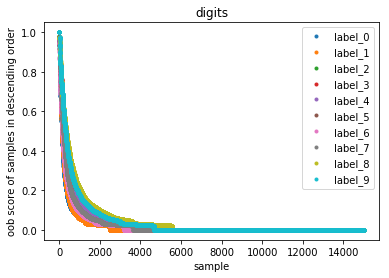

In [40]:
import matplotlib.pyplot as plt
if len(oob_scores_samples.shape) == 1: # binary
	plt.plot(sorted(oob_scores_samples.tolist(), reverse=True), '.', label='label_1')

else: # multi**
	for cls_i in range(oob_scores_samples.shape[1]):
		oob_scores_samples_cls_i = oob_scores_samples[:, cls_i]
		plt.plot(sorted(oob_scores_samples_cls_i.tolist(), reverse=True), '.', label='label_%i'%cls_i)

plt.ylabel('oob score of samples in descending order')
plt.xlabel('sample')
plt.legend()
plt.title('digits')
plt.show()

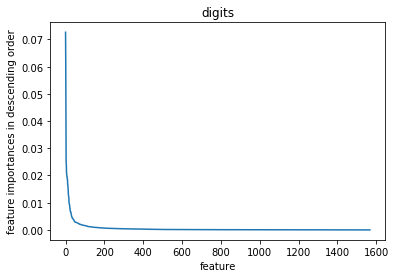

In [43]:
plt.plot(sorted(feature_importances.tolist(), reverse=True))
plt.ylabel('feature importances in descending order')
plt.xlabel('feature')
# plt.legend()
plt.title('digits')
plt.show()